In [1]:
import numpy as np
import pandas

from asodesigner.consts import *
from data_genertion.consts import *
from asodesigner.features.seq_features import get_gc_content

In [2]:
all_data = pandas.read_csv(DATA_PATH / 'data_from_article_fixed.csv')

In [3]:
all_data['gc_content'] = [get_gc_content(seq) for seq in all_data[SEQUENCE]]

In [4]:
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()

In [5]:
all_data_no_nan.loc[:, 'log_inhibition'] = -np.log(-all_data_no_nan[INHIBITION] + 100.001)

In [6]:
import ViennaRNA as RNA
from scripts.util.print import print_correlations

all_data_no_nan.loc[:, 'internal_fold'] = [RNA.fold(antisense)[1] for antisense in all_data_no_nan[SEQUENCE]]

print_correlations(all_data_no_nan, 'internal_fold', INHIBITION)
print_correlations(all_data_no_nan, 'internal_fold', 'log_inhibition')

Feature: internal_fold                      , Pearson: 0.01 , p-value: 0.038      Target: Inhibition(%)                      
Feature: internal_fold                      , Spearman: 0.00 , p-value: 0.7        Target: Inhibition(%)                      
Feature: internal_fold                      , Pearson: 0.03 , p-value: 1.7e-06    Target: log_inhibition                     
Feature: internal_fold                      , Spearman: 0.00 , p-value: 0.7        Target: log_inhibition                     


In [7]:
from scripts.data_genertion.data_handling import get_unique_human_genes

genes_u = get_unique_human_genes(all_data)
print(genes_u)

['SOD1', 'HIF1A', 'SNCA', 'KRAS', 'MALAT1', 'IRF5', 'HTRA1', 'MYH7', 'APOL1', 'DGAT2', 'KLKB1', 'YAP1', 'IRF4', 'SNHG14', 'HSD17B13']


In [8]:
from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

In [9]:
for gene_name in genes_u:
    if gene_name not in gene_to_data:
        print(f"gene : {gene_name} not found")

In [10]:
from data_genertion.data_handling import get_populated_df_with_structure_features
all_data_human_gene = get_populated_df_with_structure_features(all_data, genes_u, gene_to_data)

In [11]:
all_data_human_gene_premrna_org = all_data_human_gene[all_data_human_gene[SENSE_START] != -1]
len(all_data_human_gene_premrna_org)


29987

A431  samples:  6559
Feature: ARE                                , Pearson: 0.09 , p-value: 5.3e-14    Target: Inhibition(%)                      
Feature: ARE                                , Spearman: 0.10 , p-value: 1.6e-15    Target: Inhibition(%)                      
Feature: ARE                                , Pearson: 0.08 , p-value: 8.2e-12    Target: log_inhibition                     
Feature: ARE                                , Spearman: 0.10 , p-value: 1.6e-15    Target: log_inhibition                     
NCI-H460  samples:  18
SH-SY5Y  samples:  1767
Feature: ARE                                , Pearson: 0.17 , p-value: 2.4e-12    Target: Inhibition(%)                      
Feature: ARE                                , Spearman: 0.17 , p-value: 2.3e-12    Target: Inhibition(%)                      
Feature: ARE                                , Pearson: 0.15 , p-value: 7.1e-11    Target: log_inhibition                     
Feature: ARE                                , S

/home/michael/Projects/trying/iGEM3/scripts/util/print.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(df[name1], df[name2])
/home/michael/Projects/trying/iGEM3/scripts/util/print.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = spearmanr(df[name1], df[name2])


A431  samples:  6559
Feature: SPLICING                           , Pearson: 0.12 , p-value: 2.5e-23    Target: Inhibition(%)                      
Feature: SPLICING                           , Spearman: 0.12 , p-value: 4e-23      Target: Inhibition(%)                      
Feature: SPLICING                           , Pearson: 0.11 , p-value: 2.1e-19    Target: log_inhibition                     
Feature: SPLICING                           , Spearman: 0.12 , p-value: 4e-23      Target: log_inhibition                     
NCI-H460  samples:  18
SH-SY5Y  samples:  1767
Feature: SPLICING                           , Pearson: 0.05 , p-value: 0.039      Target: Inhibition(%)                      
Feature: SPLICING                           , Spearman: 0.05 , p-value: 0.05       Target: Inhibition(%)                      
Feature: SPLICING                           , Pearson: 0.06 , p-value: 0.011      Target: log_inhibition                     
Feature: SPLICING                           , S

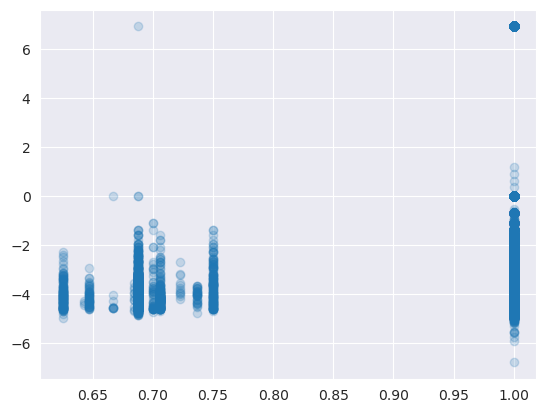

Feature: ARE                                , Pearson: 0.05 , p-value: 9.7e-19    Target: log_inhibition                     
Feature: ARE                                , Spearman: 0.05 , p-value: 4.1e-19    Target: log_inhibition                     


In [13]:
from asodesigner.util import get_antisense

rbp_motifs = [
    #
    # # # Translation regulators
    "UGUAAAUA", "UGUAUAUA", "UGUACAUA", "UGUAGAUA",  # PUM1/2 expansion for N
    "UUUU",
    # #

    #
]

are_rbp = [
        #     # Core ARE
    "AUUUA", "UUUAU",

    # Variants
    "UUUUAU", "UUAUUU", "UUUAUU", "AUUUUA",

    # Tandem / repeated AREs
    "AUUUAUUUA", "UUUAUUUAU", "AUUUAUUUUAU",

    # General AU-rich
    "UUUUU", "AUUUU", "UUUUA", "UAUUU", "UUAUU"
]

splicing_rbp = [
        # Splicing regulators
    "GAAGAA", "CGAAG",
    "UAGGGA", "UAGGGU", "UAGG",
    "UCUUC", "CUCUCU",
    "UGCU",  # MBNL1 core
]

polyadenlataion_rbp = [    # # Polyadenylation & stability
    "AAUAAA",
    "UGGUGG",
    "GGAG"
]
other_rbp = [    # # Other known motifs
    "UCAC", "UCAU", "UCCC", "UCUC",  # Nova Y = U/C → UCAY
    "CCAC", "CCAU", "CCCC", "CCUC",  # C C A Y
    "UUUUAU", "UAAA",
    "UGUG", "UGUGUG",
    "UGGAA",
    "CAUA", "CACA", "CAAA",  # IGF2BP family CAUH (H = A/C/U)
]



def rna_binding_protein_feature(aso_seq, rbp_motifs):
    """
    Simple RBP compatibility feature.

    aso_seq: str, antisense oligo sequence (5'->3')
    target_rna_seq: str, target RNA region sequence
    rbp_motifs: list of motif sequences (strings)

    Returns a score: 1.0 = fully compatible (no RBP clash),
                     0.0 = strong clash with RBP motif
    """
    target_rna_seq = get_antisense(aso_seq)
    target_rna_seq = target_rna_seq.replace('T', 'U')
    aso_len = len(aso_seq)
    best_score = 1.0

    for motif in rbp_motifs:
        for i in range(len(target_rna_seq) - len(motif) + 1):
            region = target_rna_seq[i:i+len(motif)]
            if region == motif:  # crude match
                overlap_start = max(0, i)
                overlap_end = min(i+len(motif), aso_len)
                overlap = max(0, overlap_end - overlap_start)
                if overlap > 0:
                    penalty = overlap / aso_len
                    best_score = min(best_score, 1 - penalty)
    return best_score

motifs = [are_rbp, splicing_rbp, polyadenlataion_rbp, other_rbp]
names = ['ARE', 'SPLICING', 'POLYADENALATION', 'OTHER']

for i, rbp_motif in enumerate(motifs):
    all_data_no_nan.loc[:, names[i]] = [rna_binding_protein_feature(antisense, rbp_motif) for antisense in all_data_no_nan[SEQUENCE]]

    smaller = all_data_no_nan
    # smaller = all_data_no_nan[all_data_no_nan['rbp_motifs']<1]
    cell_lines = all_data_no_nan[CELL_LINE].unique()
    for cell_line in cell_lines:
        smaller_cl = smaller[smaller[CELL_LINE]==cell_line]
        print(cell_line, " samples: ", len(smaller_cl))
        if len(smaller_cl)< 100:
            continue
        print_correlations(smaller_cl, names[i], INHIBITION)
        print_correlations(smaller_cl, names[i], 'log_inhibition')
import matplotlib.pyplot as plt

smaller_cl = all_data_no_nan[all_data_no_nan[CELL_LINE]=='A431']
# plt.scatter(smaller_cl[names[1]], smaller_cl['log_inhibition'], alpha=0.2)
plt.scatter(all_data_no_nan[names[0]], all_data_no_nan['log_inhibition'], alpha=0.2)
# plt.scatter(all_data_no_nan['rbp_motifs'], all_data_no_nan[INHIBITION], alpha=0.2)
plt.show()
print_correlations(all_data_no_nan, names[0], 'log_inhibition')


In [ ]:
from scripts.data_genertion.risearch_hybridization import populate_with_risearch_hybridization

all_data_human_gene_premrna = all_data_human_gene_premrna_org.copy()  # so Jupyter doesn't shout at me


In [ ]:
populate_with_risearch_hybridization(all_data_human_gene_premrna, genes_u, gene_to_data)

In [ ]:
import pandas as pd
all_data_human_gene_premrna = pd.read_csv('out.csv')

In [ ]:
all_data_human_gene_premrna.loc[:, 'log_inhibition'] = -np.log(-all_data_human_gene_premrna[INHIBITION] + 100.001)
all_data_human_gene_premrna['Target_gene']

In [ ]:
print(all_data_human_gene_premrna.columns)

In [ ]:
import matplotlib.pyplot as plt

test = all_data_human_gene_premrna
# test = all_data_human_gene_premrna[all_data_human_gene_premrna['Linkage'] == 'phosphorothioate']
# test = all_data_human_gene_premrna[all_data_human_gene_premrna['Target_gene'] == 'APOL1']
# test = test.sort_values(by=['3on_target_energy_max800'], ascending=[False])

# for cutoff in ['800', '900', '700']:
for dsm in ['dsm_su95_rev_wGU_pos']:
# for dsm in ['dsm_su95_rev_woGU_pos']:
    # for dsm in ['dsm_su95_rev_woGU_pos', 'dsm_su95_rev_wGU_pos', 'dsm_slh04_woGU_pos']:

    # for base in [0, 120, 126, 132, 138, 144]:
    # for base in [0, 100, 138, 150]:
    for base in [100, 138, 150]:
        for cutoff in [400]:
            for metric in ['on_target_energy_max']:
                for temp in [37, 50]:
                    for transpose in [True, False]:
                        # for metric in ['on_target_energy_max', 'on_target_energy_sum', 'on_target_energy_fits']:
                        #     print_correlations(test, dsm + str(base) + '6' + metric + str(cutoff), 'log_inhibition')
                        # print_correlations(test, dsm + str(base) + '6' + 't' + str(temp) + metric + str(cutoff), 'log_inhibition')
                        # print_correlations(test, dsm + str(base) + '5' + 't' + str(temp) + metric + str(cutoff), 'log_inhibition')
                        print_correlations(test, dsm + str(base) + '4' + 't' + str(temp) + str(transpose) + metric + str(cutoff), 'log_inhibition')
                        print_correlations(test, dsm + str(base) + '6' + 't' + str(temp)  +str(transpose) +  metric + str(cutoff), 'log_inhibition')
                        # print_correlations(test, dsm + str(base) + '2' + 't' + str(temp)  +str(transpose) +  metric + str(cutoff), 'log_inhibition')
                        # print_correlations(test, dsm + str(base) + '2' + 't' + str(temp) + metric + str(cutoff), 'log_inhibition')
                        # print_correlations(test, dsm + str(base) + '0' + metric + str(cutoff), 'log_inhibition')
                        # print_correlations(test, metric + str(cutoff), 'log_inhibition')
    print_correlations(test, 'dsm_su95_rev_wGU_pos1382t50Falseon_target_energy_max400', 'log_inhibition')

In [ ]:
len(set(list(test['dsm_slh04_woGU_pos1384t37Falseon_target_energy_max400'])))

In [ ]:
len(set(list(test['dsm_su95_rev_wGU_pos1442on_target_energy_max800'])))

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(test['dsm_su95_rev_woGU_pos1384t50Trueon_target_energy_max400'], test['log_inhibition'], alpha=0.02)
# plt.scatter(test['dsm_su95_rev_wGU_pos1504on_target_energy_max800'], test['log_inhibition'], alpha=0.05)
# plt.scatter(test['dsm_su95_rev_wGU_pos1505on_target_energy_max800'], test['log_inhibition'], alpha=0.05)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

test = all_data_human_gene_premrna[all_data_human_gene_premrna[CANONICAL_GENE] == 'SNCA']
test = test.sort_values(by=['dsm_slh04_woGU_pos04t37Falseon_target_energy_max800'], ascending=[False])
print(test.tail(5))
plt.scatter(test['dsm_slh04_woGU_pos04t37Falseon_target_energy_max800'], test['log_inhibition'], alpha=0.05)
plt.show()

In [ ]:
from scripts.data_genertion.data_handling import get_populate_fold
from asodesigner.fold import calculate_energies, get_weighted_energy
from asodesigner.util import get_antisense

# fold_variants = [(40, 15), (60, 15), (80, 15), (100, 15), (60, 25), (80, 25), (100, 25), (80, 40), (100, 40)]
fold_variants = [(40, 15)]
all_data_human_gene_premrna_no_nan = get_populate_fold(all_data_human_gene_premrna, genes_u, gene_to_data, fold_variants)


In [ ]:
fold_feature_names = ['on_target_fold_openness', 'on_target_fold_openness_normalized']
fold_features = []
for (window_size, step_size) in fold_variants:
    for feature_name in fold_feature_names:
        fold_features.append(feature_name + str(window_size) + "_" + str(step_size))

In [ ]:
all_data_human_gene_premrna_no_nan.loc[:, 'log_inhibition'] = -np.log(-all_data_no_nan[INHIBITION] + 100.001)


In [ ]:
test = all_data_human_gene_premrna_no_nan
# test = all_data_human_gene_premrna_no_nan[all_data_human_gene_premrna_no_nan[INHIBITION] > 0]


for feature_name in fold_features:
    print_correlations(test, feature_name, INHIBITION, p_value_threshold=0.05)
    print_correlations(test, feature_name, 'log_inhibition', p_value_threshold=0.05)

feature = fold_features[1]
plt.scatter(test[feature], test[INHIBITION], alpha=0.02)
plt.show()


In [ ]:
from scripts.data_genertion.data_handling import populate_features

populate_features(all_data_human_gene_premrna_no_nan, 'self_energy')

print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy', 'log_inhibition')

In [ ]:
populate_features(all_data_human_gene_premrna_no_nan, 'internal_fold')
print_correlations(all_data_human_gene_premrna_no_nan, 'internal_fold', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'internal_fold', 'log_inhibition')


In [ ]:
all_data_human_gene_premrna_no_nan.loc[:, 'gc_content_5_prime_5'] = [get_gc_content(sequence[:5]) for sequence in
                                                                     all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'gc_content_3_prime_5'] = [get_gc_content(sequence[-5:]) for sequence in
                                                                     all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'first_nucleotide'] = [sequence[0] for sequence in
                                                                 all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'second_nucleotide'] = [sequence[2] for sequence in
                                                                  all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'gc_content_5_prime_5', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'gc_content_5_prime_5', 'log_inhibition')
print_correlations(all_data_human_gene_premrna_no_nan, 'gc_content_3_prime_5', 'log_inhibition')
print_correlations(all_data_human_gene_premrna_no_nan, 'gc_content_3_prime_5', 'log_inhibition')


In [ ]:
import primer3

all_data_human_gene_premrna_no_nan.loc[:, 'self_energy'] = [primer3.calc_homodimer(antisense).dg for antisense in
                                                            all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'self_energy_log'] = -np.log(
    2500 - all_data_human_gene_premrna_no_nan.loc[:, 'self_energy'])

print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy', 'log_inhibition')
print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy_log', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy_log', 'log_inhibition')

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(all_data_human_gene_premrna_no_nan['self_energy_log'], all_data_human_gene_premrna_no_nan['log_inhibition'],
            alpha=0.1)
plt.show()

In [ ]:
print_correlations(all_data_human_gene_premrna_no_nan, TREATMENT_PERIOD, INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, TREATMENT_PERIOD, 'log_inhibition')
plt.scatter(all_data_human_gene_premrna_no_nan[TREATMENT_PERIOD], all_data_human_gene_premrna_no_nan[INHIBITION],
            alpha=0.05)
plt.show()

In [ ]:
tmp = all_data_human_gene_premrna_no_nan.copy()
tmp = tmp.dropna(subset=[DENSITY]).copy()
tmp.loc[:, 'log_density'] = np.log(tmp[DENSITY])

print_correlations(tmp, DENSITY, INHIBITION)
print_correlations(tmp, DENSITY, 'log_inhibition')
print_correlations(tmp, 'log_density', INHIBITION)
print_correlations(tmp, 'log_density', 'log_inhibition')
plt.scatter(tmp[DENSITY], tmp[INHIBITION], alpha=0.05)
plt.show()

In [ ]:
all_data_human_gene_premrna_no_nan.loc[:, 'mrna_length'] = [len(gene_to_data[gene].full_mrna) for gene in
                                                            all_data_human_gene_premrna_no_nan[CANONICAL_GENE]]
all_data_human_gene_premrna_no_nan.loc[:, 'normalized_start'] = all_data_human_gene_premrna_no_nan[SENSE_START] / \
                                                                all_data_human_gene_premrna_no_nan['mrna_length']

print_correlations(all_data_human_gene_premrna_no_nan, 'normalized_start', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'normalized_start', 'log_inhibition')

plt.scatter(all_data_human_gene_premrna_no_nan['normalized_start'],
            all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.05)
plt.show()

In [ ]:
from hybridization.hybridization_features import get_exp_psrna_hybridization_normalized, get_exp_psrna_hybridization
from hybridization.md_weights import get_md_psrna_hybridization, get_md_psrna_hybridization_normalized
import matplotlib.pyplot as plt
# table from article: https://pubs.acs.org/doi/10.1021/acs.jpcb.4c08344

all_data_human_gene_premrna_no_nan.loc[:, 'ps_hybr'] = [get_md_psrna_hybridization(antisense.replace('T', 'U'), algo='gb') for
                                                        antisense in all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'ps_hybr_norm'] = [get_md_psrna_hybridization_normalized(antisense.replace('T', 'U'), algo='gb') for
                                                        antisense in all_data_human_gene_premrna_no_nan[SEQUENCE]]

all_data_human_gene_premrna_no_nan.loc[:, 'exp_ps_hybr'] = [get_exp_psrna_hybridization(antisense.replace('T', 'U'), temp=37) for
                                                        antisense in all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'exp_ps_hybr_norm'] = [get_exp_psrna_hybridization_normalized(antisense.replace('T', 'U'), temp=37) for
                                                        antisense in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'ps_hybr', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'ps_hybr', 'log_inhibition')
print_correlations(all_data_human_gene_premrna_no_nan, 'exp_ps_hybr', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'exp_ps_hybr', 'log_inhibition')

plt.scatter(all_data_human_gene_premrna_no_nan['exp_ps_hybr'],all_data_human_gene_premrna_no_nan['log_inhibition'],alpha=0.05)
plt.plot()

In [ ]:
from hybridization.md_weights import get_md_2_moe_hybridization, get_md_2_moe_hybridization_norm

moe_pattern = 'MMMMMddddddddddMMMMM'
filtered = all_data_human_gene_premrna_no_nan.copy()
# filtered = filtered[filtered['Chemical_Pattern'] == moe_pattern]
filtered = filtered[filtered['Linkage'] == 'phosphorothioate']
filtered = filtered[filtered['Cell_line'] == 'HepG2']
filtered = filtered[filtered['Modification'] == 'MOE/5-methylcytosines/deoxy']

def get_moe(pattern):
    moe = []
    for i, n in enumerate(pattern):
        if n == "M":
           moe.append(i)
    return moe

filtered.loc[:, 'moe_hybr'] = [get_md_2_moe_hybridization(row[0].replace('T', 'U'), get_moe(row[1])) for
                               row in zip(filtered[SEQUENCE], filtered['Chemical_Pattern'])]

filtered.loc[:, 'moe_hybr_norm'] = [get_md_2_moe_hybridization_norm(row[0].replace('T', 'U'), get_moe(row[1])) for
                               row in zip(filtered[SEQUENCE], filtered['Chemical_Pattern'])]

print_correlations(filtered, 'moe_hybr_norm', INHIBITION)
print_correlations(filtered, 'dsm_su95_rev_wGU_pos1384t37Falseon_target_energy_max400', INHIBITION)
print_correlations(filtered, 'ps_hybr', INHIBITION)
# print_correlations(filtered, 'moe_hybr_log', INHIBITION)
# print_correlations(filtered, 'moe_hybr_log', 'log_inhibition')

plt.scatter(filtered['moe_hybr_norm'] ,
            filtered['log_inhibition'], alpha=0.05)
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from itertools import product
from scripts.data_genertion.risearch_hybridization import RNA_TABLES
from sklearn.neural_network import MLPRegressor
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer
import pandas as pd
from scipy.stats import pearsonr, spearmanr


filtered = all_data_human_gene_premrna_no_nan.copy()
filtered = filtered[filtered['Cell line organism'] == 'human']
print(len(filtered))
# filtered.loc[:, 'moe_hybr'] = [get_md_2_moe_hybridization(row[0].replace('T', 'U'), get_moe(row[1])) for
#                                row in zip(filtered[SEQUENCE], filtered['Chemical_Pattern'])]
filtered = filtered.dropna(subset=[INHIBITION]).copy()
filtered = filtered.dropna(subset=[DENSITY]).copy()

filtered['log_volume'] = np.log(filtered[VOLUME])
filtered.loc[:, 'log_inhibition'] = -np.log(-filtered[INHIBITION] + 101)
filtered.loc[:, 'log_density'] = np.log(filtered[DENSITY])
filtered.loc[:, SENSE_LENGTH] = [len(sequence) for sequence in filtered[SEQUENCE]]
filtered.loc[:, SENSE_LENGTH] = filtered.loc[:, SENSE_LENGTH].astype(float)
filtered['gc_deviation'] = np.abs(0.5 - filtered['gc_content'])
filtered['self_energy_log_squared'] = filtered['self_energy_log'] ** 2

ONE_HOT_FEATURE_NAMES = [
                         # CELL_LINE,
                         DENSITY,
                         TRANSFECTION,
                         'first_nucleotide', 'second_nucleotide',
                         # MODIFICATION,
                         SENSE_TYPE]
for feature in ONE_HOT_FEATURE_NAMES:
    filtered = pd.get_dummies(filtered, columns=[feature]).copy()


# filtered['self_energy_squared'] = filtered['self_energy'] ** 2


# features_base = ['log_volume', TREATMENT_PERIOD, VOLUME]
features_base = ['gc_content', 'gc_deviation',
                 # SENSE_LENGTH,
                 # 'normalized_start',
                 # SENSE_START,
                 'self_energy_log',
                 'self_energy_log_squared', 'internal_fold', 'gc_content_3_prime_5', 'gc_content_5_prime_5',
                 # 'dsm_su95_rev_wGU_pos05on_target_energy_max800',
                 # 'dsm_slh04_woGU_pos04t50on_target_energy_max800',
                 # 'dsm_slh04_woGU_pos1384t50Trueon_target_energy_max800',
                 # 'dsm_su95_rev_wGU_pos02on_target_energy_max800'
                 ]
# dsm_su95_rev_wGU_pos
experiment_features = [VOLUME, 'log_volume', TREATMENT_PERIOD, 'log_density']
# experiment_features = []

one_hot_encoded_features = []
for one_hot_feature in ONE_HOT_FEATURE_NAMES:
    one_hot_encoded_features.append(
        [feature for feature in filtered.columns if one_hot_feature in feature and one_hot_feature != feature])
# Flatten the list of list to a single big list
flat_one_hot_encoded_features = [feature for sublist in one_hot_encoded_features for feature in sublist]

features = features_base + experiment_features + fold_features + flat_one_hot_encoded_features

# filtered = all_data_human_gene_premrna_no_nan
common_chemical_pattern = 'CCCddddddddddCCC'
moe_pattern = 'MMMMMddddddddddMMMMM'

# filtered = filtered[filtered['Chemical_Pattern'] == common_chemical_pattern]
# filtered = filtered[filtered['Chemical_Pattern'] == moe_pattern]
# filtered = filtered[filtered['Linkage'] == 'phosphorothioate']
# filtered = filtered[filtered['Cell_line'] == 'HepaRG']

# filtered = filtered[filtered['Linkage'] == 'phosphorothioate']
print(len(filtered))
# filtered = filtered[filtered['Cell_line'] == 'HepG2']
print(len(filtered))
# filtered = filtered[filtered['Modification'] == 'MOE/5-methylcytosines/deoxy']
print(len(filtered))
# filtered = filtered[filtered[VOLUME] == 2500]
print(len(filtered))


def get_model(my_feature, filtered, features):
    current_features = list(features)
    current_features.append(my_feature)

    # print("Used features: ", current_features)


    # filtered = filtered[filtered[CANONICAL_GENE] == 'IRF5']
    # filtered = filtered[filtered[INHIBITION] > 0]
    # filtered = filtered[filtered[VOLUME] == 4000]
    # filtered = filtered[filtered[INHIBITION] > 70]
    # print("Length filtered: ", len(filtered))
    # train, test = train_test_split(filtered, test_size=0.2, random_state=0, stratify=filtered[CANONICAL_GENE])
    train, test = train_test_split(filtered, test_size=0.2)

    print("Test: ", len(test))
    print("Train: ", len(train))
    X = train[current_features]
    y = train['log_inhibition']
    # x_tag = X
    # y_tag = y
    #
    # weight = VOLUME
    #
    # # Multiply the values via numpy without changing the column names
    # multiplier = np.sqrt(X[weight]).values.reshape(-1, 1)
    # X_tag = pd.DataFrame(
    #     X[features].values * multiplier,
    #     index=X.index,
    #     columns=X[features].columns)
    #
    # y_tag = y * np.sqrt(X[weight])

    # model = LinearRegression()
    # model.fit(X_tag, y_tag)
    # model = KNeighborsRegressor(n_neighbors=20)
    # model = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_leaf=10, n_jobs=-1)
    model = RandomForestRegressor()



    # model = RandomForestRegressor(random_state=42, n_jobs=-1)

    # model.fit(X,y)
    model.fit(train[current_features], train['log_inhibition'])
    return model, X, y, current_features, test, train

models = []
my_features = []
minimal_scores = [800]
for dsm, base, prefix, score, temp, transpose  in list(product(RNA_TABLES, [138], [4,6], minimal_scores, [37, 50], [True, False])):
    my_feature = f"{dsm}{base}{prefix}t{temp}{transpose}on_target_energy_max{score}"
    my_features.append(my_feature)

# my_features.append('moe_hybr')
my_features.append('ps_hybr')
my_features.append('exp_ps_hybr')
# my_features.append('dsm_slh04_woGU_pos1382t37Falseon_target_energy_max400')
# my_features.append('dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max400')
# my_features.append('dsm_su95_rev_woGU_pos1382t37Falseon_target_energy_max400')

for my_feature in my_features:
    models.append(get_model(my_feature, filtered, features))

In [ ]:
from sklearn.model_selection import KFold
from scipy.stats import hmean
cv = KFold(n_splits=5, shuffle=True, random_state=42)


from scipy import stats
def spearman_score(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred).correlation ** 2
spearman_scorer = make_scorer(spearman_score, greater_is_better=True)

feature_score = []
for model, X, y, current_features, test, train in models:
    print(current_features[-1])
    # baseline_score = cross_val_score(model, X, y, cv=cv, n_jobs=-1).mean()
    # print("Baseline score: ", baseline_score)

    # spearman_score_num = cross_val_score(model, X[current_features], y, cv=cv, scoring=spearman_scorer, n_jobs=-1).mean()
    # print("Spearman score train: ", spearman_score_num)

    spearman_score_num = cross_val_score(model, filtered[current_features], filtered['log_inhibition'], cv=cv, scoring=spearman_scorer, n_jobs=-1).mean()
    print("Spearman score everything: ", spearman_score_num)

    feature_score.append((current_features[-1], spearman_score_num))
# feature_score


In [ ]:
from scipy.stats import pearsonr, spearmanr

for model, X, y, current_features, test, train in models:
    train_filtered = train.copy()
    test_filtered = test.copy()

    predicted = model.predict(test_filtered[current_features])

    # test_features = test_filtered[features]
    # predicted = model.predict(test_features)
    # y_test = test_filtered['log_inhibition'] / np.sqrt(test_filtered[weight])
    y_test = test_filtered['log_inhibition']

    print(current_features[-1])
    print("Train correlations:")
    train_predicted = model.predict(train_filtered[current_features])
    corr, p_value = pearsonr(train_filtered['log_inhibition'], train_predicted)
    print("Pearson Corr: ", corr, " p_value: ", p_value)
    corr, p_value = spearmanr(train_filtered['log_inhibition'], train_predicted)
    print("Spearman Corr: ", corr, " p_value: ", p_value)

    print("Test correlations:")
    corr, p_value = pearsonr(y_test, predicted)
    print("TPearson Corr: ", corr, " p_value: ", p_value)
    corr, p_value = spearmanr(y_test, predicted)
    print("TSpearman Corr: ", corr, " p_value: ", p_value)
#
#
# plt.scatter(predicted, y_test, alpha=0.2)
# # plt.scatter(y_test, test['gc_content'])
# x = np.linspace(np.min(predicted), np.max(predicted), 100)
# plt.plot(x, x, color='red')
#
# plt.xlabel('Predicted Inhibition')
# plt.ylabel('Actual Inhibition')
# plt.title('Predicted vs Actual Inhibition')
# plt.show()

In [ ]:
from scipy.stats import pearsonr, spearmanr

for model, X, y, current_features, test, train in models:
    train_filtered = train.copy()
    test_filtered = test.copy()

    predicted = model.predict(test_filtered[current_features])

    # test_features = test_filtered[features]
    # predicted = model.predict(test_features)
    # y_test = test_filtered['log_inhibition'] / np.sqrt(test_filtered[weight])
    y_test = test_filtered['log_inhibition']

    print(current_features[-1])
    print("Train correlations:")
    train_predicted = model.predict(train_filtered[current_features])
    corr, p_value = pearsonr(train_filtered['log_inhibition'], train_predicted)
    print("Pearson Corr: ", corr, " p_value: ", p_value)
    corr, p_value = spearmanr(train_filtered['log_inhibition'], train_predicted)
    print("Spearman Corr: ", corr, " p_value: ", p_value)

    print("Test correlations:")
    corr, p_value = pearsonr(y_test, predicted)
    print("TPearson Corr: ", corr, " p_value: ", p_value)
    corr, p_value = spearmanr(y_test, predicted)
    print("TSpearman Corr: ", corr, " p_value: ", p_value)
#
#
# plt.scatter(predicted, y_test, alpha=0.2)
# # plt.scatter(y_test, test['gc_content'])
# x = np.linspace(np.min(predicted), np.max(predicted), 100)
# plt.plot(x, x, color='red')
#
# plt.xlabel('Predicted Inhibition')
# plt.ylabel('Actual Inhibition')
# plt.title('Predicted vs Actual Inhibition')
# plt.show()

In [ ]:
from sklearn.model_selection import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(model, X, y, cv=5, n_permutations=100, scoring='r2')
print(score, permutation_scores, pvalue)

In [ ]:
plt.scatter(filtered['self_energy_log_squared'], filtered['log_inhibition'], alpha=0.1)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import rankdata


def partial_corr(x, y, z):
    # Regress x on z
    X = sm.add_constant(z)
    model_x = sm.OLS(x, X).fit()
    res_x = model_x.resid

    # Regress y on z
    model_y = sm.OLS(y, X).fit()
    res_y = model_y.resid

    # Compute correlation between the residuals
    return np.corrcoef(res_x, res_y)[0, 1]


def partial_spearman_corr(x, y, z):
    # Convert variables to ranks
    rx = rankdata(x)
    ry = rankdata(y)
    rz = rankdata(z)

    # Regress rx on rz
    X = sm.add_constant(rz)
    model_x = sm.OLS(rx, X).fit()
    res_x = model_x.resid

    # Regress ry on rz
    model_y = sm.OLS(ry, X).fit()
    res_y = model_y.resid

    # Compute the Pearson correlation between the residuals
    return np.corrcoef(res_x, res_y)[0, 1]


for gene in genes_u:
    t = filtered[filtered[CANONICAL_GENE] == gene]
    print("Gene:", gene)
    try:
        pcorr = partial_spearman_corr(t['self_energy'], t['log_inhibition'], t['gc_content'])
        print(pcorr)
    except:
        pass

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(filtered[features], filtered['log_inhibition'])

# Get the feature importances
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)



In [ ]:
for index, row in importance_df.iterrows():
    print(f"{row['Feature']:<40} {row['Importance']:.3}")


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
from sklearn.inspection import permutation_importance

def spearman_score(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred).correlation ** 2
spearman_scorer = make_scorer(spearman_score, greater_is_better=True)

for model, X, y, current_features, test, train, in models:

    result = permutation_importance(
        model,
        X[current_features],
        y,
        n_repeats=100,       # shuffle each feature 10 times
        random_state=42,
        scoring=spearman_scorer,
        n_jobs=-1,
    )

    imp_df = pd.DataFrame({
        'feature': current_features,
        'importance': result.importances_mean,
        'std': result.importances_std
    }).sort_values('importance', ascending=False)

    # spearman_score_num = cross_val_score(model, filtered[current_features], filtered['log_inhibition'], cv=cv, scoring=spearman_scorer, n_jobs=-1).mean()
    # print("Spearman score everything: ", spearman_score_num)
    print(imp_df.head(10))

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
from sklearn.inspection import permutation_importance

def spearman_score(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred).correlation ** 2
spearman_scorer = make_scorer(spearman_score, greater_is_better=True)

for model, X, y, current_features, test, train, in models:

    result = permutation_importance(
        model,
        X[current_features],
        y,
        n_repeats=100,       # shuffle each feature 10 times
        random_state=42,
        scoring=spearman_scorer,
        n_jobs=-1,
    )

    imp_df = pd.DataFrame({
        'feature': current_features,
        'importance': result.importances_mean,
        'std': result.importances_std
    }).sort_values('importance', ascending=False)

    # spearman_score_num = cross_val_score(model, filtered[current_features], filtered['log_inhibition'], cv=cv, scoring=spearman_scorer, n_jobs=-1).mean()
    # print("Spearman score everything: ", spearman_score_num)
    print(imp_df.head(10))

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
from sklearn.inspection import permutation_importance

def spearman_score(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred).correlation ** 2
spearman_scorer = make_scorer(spearman_score, greater_is_better=True)

for model, X, y, current_features, test, train, in models:

    result = permutation_importance(
        model,
        X[current_features],
        y,
        n_repeats=100,       # shuffle each feature 10 times
        random_state=42,
        scoring=spearman_scorer,
        n_jobs=-1,
    )

    imp_df = pd.DataFrame({
        'feature': current_features,
        'importance': result.importances_mean,
        'std': result.importances_std
    }).sort_values('importance', ascending=False)

    # spearman_score_num = cross_val_score(model, filtered[current_features], filtered['log_inhibition'], cv=cv, scoring=spearman_scorer, n_jobs=-1).mean()
    # print("Spearman score everything: ", spearman_score_num)
    print(imp_df.head(10))

In [ ]:
dsm_su95_rev_wGU_pos

In [ ]:
print("The baseline is: ", baseline_score)
print("The spearman baseline is: ", spearman_score)
cv = 5
scorer = spearman_scorer
jobs = 1
feature_importances = []

# for feature in features_base + on_target_energy_features + fold_features:
for feature in features_base:
    score_without_feature = cross_val_score(model, X.drop(columns=[feature]), y, cv=cv, scoring=scorer,
                                            n_jobs=jobs).mean()
    # print(f"Dropping {feature}: performance drop = {baseline_score - score_without_feature}")
    feature_importances.append((feature, float(baseline_score - score_without_feature)))

print("Done base features")

for i in range(len(one_hot_encoded_features)):
    feature_name = ONE_HOT_FEATURE_NAMES[i]
    feature = one_hot_encoded_features[i]

    score_without_feature = cross_val_score(model, X.drop(columns=feature), y, cv=cv, scoring=scorer,
                                            n_jobs=jobs).mean()
    performance_diff = baseline_score - score_without_feature
    feature_importances.append((feature_name, float(performance_diff)))

#
# score_without_on_target_energy = cross_val_score(model, X.drop(columns=on_target_energy_features), y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
# performance_drop_all_on_target_energy = baseline_score - score_without_on_target_energy
# feature_importances.append(("All on target energy", float(performance_drop_all_on_target_energy)))

score_without_fold_features = cross_val_score(model, X.drop(columns=fold_features), y, cv=cv, scoring=scorer,
                                              n_jobs=jobs).mean()
performance_drop_fold_features = baseline_score - score_without_fold_features
feature_importances.append(("Fold features", float(performance_drop_fold_features)))

sorted_data = sorted(feature_importances, key=lambda x: x[1], reverse=True)
for datum in sorted_data:
    print(datum)


In [ ]:
print(filtered.columns)

for gene in genes_u:
    print("Gene:", gene)

    try:
        predicted_gene = model.predict(filtered[filtered[CANONICAL_GENE] == gene][features])
        y_gene = filtered[filtered[CANONICAL_GENE] == gene]['log_inhibition']
        corr, p_value = pearsonr(y_gene, predicted_gene)
        print("Pearson Corr: ", corr, " p_value: ", p_value)
        corr, p_value = spearmanr(y_gene, predicted_gene)
        print("Spearman Corr: ", corr, " p_value: ", p_value)
    except:
        pass
# plt.scatter(predicted, y)
# plt.show()

In [ ]:
for gene in genes_u:
    print("Gene: ", gene)
    print(len(set(list(
        all_data_human_gene_premrna_no_nan[all_data_human_gene_premrna_no_nan[CANONICAL_GENE] == gene][SEQUENCE]))))

In [ ]:
subset = ['Sequence', 'Chemical_Pattern', 'Smiles', 'Linkage', 'Location', 'Modification', 'Primer_probe_set', 'ISIS',
          'Cell_line', VOLUME, DENSITY]
result = all_data_human_gene_premrna_no_nan.groupby(subset).filter(lambda x: len(x) > 20)
# result = all_data_human_gene_premrna_no_nan
result = result.sort_values(by=['Sequence'])
result